In [1]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

## for printing image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

torch.cuda.is_available()

True

In [2]:
from pathlib import Path
import glob, os
from collections import defaultdict


cwd = Path("C:\\Users\\piyush\\Desktop\\mtp\\expt\\")
dict_for_uts = pd.read_csv(cwd/'dict_for_uts.csv').iloc[:,1:4]
dict_for_uts[:4]

all_files = Path(cwd/"FORCE").glob("*.xls")

rpm_dict, vel_dict = defaultdict(list), defaultdict(list)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter="\t")
    df = df.loc[df['X-Pos'] > 5+df['X-Pos'][0]]
    m = df['Z-Load'][:200].mean()
    df = df.loc[df['Z-Load'] > m*(1-0.1)]
    li.append(df)

for df in li:
    rpm = dict_for_uts.iloc[(dict_for_uts['rpm']-int(round(df.iloc[0:100]["Spindle RPM"].mean(), -2))).abs().argsort()[0]]["rpm"]
    vel = int(round(df.iloc[0:50]['X-Velocity'].mean(), -1))
    uts = dict_for_uts.loc[(dict_for_uts['rpm']==rpm) & (dict_for_uts['ws']==vel)]['UTS (MPa)'].iloc[0]
    df["UTS"] = uts
    rpm_dict[int(rpm)].append(df)
    vel_dict[vel].append(df)

In [3]:
min(pd.concat(li)['UTS']), max(pd.concat(li)['UTS'])

(146.2, 249.3077)

In [4]:
from sklearn import preprocessing

class WeldData(Dataset):
    def __init__(self, li):
        mms = preprocessing.MinMaxScaler(feature_range=(0, 1))
        xy = mms.fit_transform(pd.concat(li)[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values)
#         xy = pd.concat(li)[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, 0:-1])
        self.y_data = torch.from_numpy(xy[:, [-1]])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [9]:
class DataLoaderWeld:
    def __init__(self, dataset_size):
        self.dataset_size = dataset_size
    
    # Index generator for simple train, val and test splits
    def simple_index_generator(self, validation_split=.15, test_split=.15):
        indices = list(range(self.dataset_size))
        split1, split2 = int(np.floor(validation_split * dataset_size)), int(np.floor(test_split * dataset_size))

        random_seed= 42
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        return (indices[split1+split2:], indices[:split1], indices[split1:split1+split2])
    
    # Index Generator for k-fold cross validation 
    def index_generate(self, k):
        random_seed = 42
        indices = list(range(self.dataset_size))
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        split_size = int(self.dataset_size/k)
        test_indices = indices[-split_size:]

        # train_val_set_size
        remain_size = int((self.dataset_size-split_size)/k)
        for i in range(k):
            yield (indices[:i*remain_size]+indices[(i+1)*remain_size-1:], 
                   indices[i*remain_size:(i+1)*remain_size], 
                   test_indices)
    
    # Returns the dataloader dicts for train, val and test
    def dataset_prepare(self, dataset, method='k-fold', k=10, bs=32): # method is either k-fold or simple
        def loader_prepare(dataset, index_tup):
            train_indices, val_indices, test_indices = index_tup[0], index_tup[1], index_tup[2]
            train_sampler = SubsetRandomSampler(train_indices)
            valid_sampler = SubsetRandomSampler(val_indices)
            test_sampler = SubsetRandomSampler(test_indices)

            train_loader = DataLoader(dataset, batch_size=bs, sampler=train_sampler)
            validation_loader = DataLoader(dataset, batch_size=bs, sampler=valid_sampler)
            test_loader = DataLoader(dataset, batch_size=bs, sampler=test_sampler)
            return ({"train": train_loader, "valid": validation_loader, "test": test_loader}, 
                {"train": len(train_indices), "valid": len(val_indices), "test": len(test_indices)})
        
        dataset_size = len(dataset)
        
        if method=="simple":
            return loader_prepare(dataset, self.simple_index_generator(validation_split=.15, test_split=.15))
        else:
            # k-fold index generation
            for train_indices, val_indices, test_indices in self.index_generate(k):
                data_loaders, data_lengths = loader_prepare(dataset, (train_indices, val_indices, test_indices))
                yield data_loaders, data_lengths

In [10]:
dataset = WeldData(li)

loader = DataLoaderWeld(len(dataset))

In [11]:
g = loader.dataset_prepare(dataset)

In [12]:
data_loaders, data_lengths = next(g)

In [13]:
data_lengths

{'train': 18486, 'valid': 1828, 'test': 2031}

In [14]:
for i in data_loaders['train']:
    print(i[0].size());break

torch.Size([32, 3])


In [64]:
class SimpleANN(nn.Module):
    def __init__(self, cuda=True):
        super(SimpleANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(5, 8),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(8, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
        if(torch.cuda.is_available() and cuda):
            self.cuda()
    
    def forward(self, t):
        return self.fc(t)


In [73]:
model = SimpleANN()
# model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

n_epochs = 500
k_fold_size = 10

In [74]:
# Training loop
generator = loader.dataset_prepare(dataset, method='k-fold', k=k_fold_size, bs=32)
data_loaders, data_lengths = next(generator)
for epoch in range(n_epochs):
    
    if(epoch and epoch%10==0):        
        if(epoch%(10*k_fold_size)==0):
            generator = loader.dataset_prepare(dataset, method='k-fold', k=k_fold_size, bs=32)
            
        print("\nChanging the X-Validation set\n")
        data_loaders, data_lengths = next(generator)
        
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    for phase in ['train', 'valid']:
        if phase == 'train':
#             scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)

        running_loss = 0.0
        for data in data_loaders[phase]:
            # get the inputs
            inputs, labels = data

            inputs, labels = Variable(inputs).cuda().float(), Variable(labels).cuda().float()

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(inputs)

            # Compute and print loss
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()
                
            running_loss += loss.item()
        epoch_loss = running_loss * bs / data_lengths[phase]
        print("{} Loss: {:.6f}".format(phase, epoch_loss))
    scheduler.step(epoch_loss)
    if(epoch%5==0):
        torch.save(model.state_dict(), cwd/'saved_models'/'model_{}.pth'.format(epoch))
    

Epoch 0/499
----------
train Loss: 0.266995
valid Loss: 0.094647
Epoch 1/499
----------
train Loss: 0.057009
valid Loss: 0.041565
Epoch 2/499
----------
train Loss: 0.040114
valid Loss: 0.039311
Epoch 3/499
----------
train Loss: 0.039704
valid Loss: 0.039139
Epoch 4/499
----------
train Loss: 0.035519
valid Loss: 0.020468
Epoch 5/499
----------
train Loss: 0.016970
valid Loss: 0.013922
Epoch 6/499
----------
train Loss: 0.012927
valid Loss: 0.011278
Epoch 7/499
----------
train Loss: 0.011062
valid Loss: 0.010176
Epoch 8/499
----------
train Loss: 0.010545
valid Loss: 0.010377
Epoch 9/499
----------
train Loss: 0.010277
valid Loss: 0.010883
Changing the X-Validation set
Epoch 10/499
----------
train Loss: 0.010095
valid Loss: 0.009348
Epoch 11/499
----------
train Loss: 0.009824
valid Loss: 0.008942
Epoch 12/499
----------
train Loss: 0.009529
valid Loss: 0.009445
Epoch 13/499
----------
train Loss: 0.009211
valid Loss: 0.008679
Epoch 14/499
----------
train Loss: 0.008984
valid Loss:

Epoch 231/499
----------
train Loss: 0.000592
valid Loss: 0.001025
Epoch 232/499
----------
train Loss: 0.000593
valid Loss: 0.001018
Epoch 233/499
----------
train Loss: 0.000593
valid Loss: 0.001046
Epoch 234/499
----------
train Loss: 0.000593
valid Loss: 0.001046
Epoch 235/499
----------
train Loss: 0.000593
valid Loss: 0.001050
Epoch 236/499
----------
train Loss: 0.000593
valid Loss: 0.001021
Epoch 237/499
----------
train Loss: 0.000593
valid Loss: 0.001023
Epoch 238/499
----------
train Loss: 0.000592
valid Loss: 0.001076
Epoch 239/499
----------
train Loss: 0.000593
valid Loss: 0.001020
Changing the X-Validation set
Epoch 240/499
----------
train Loss: 0.000639
valid Loss: 0.000555
Epoch 241/499
----------
train Loss: 0.000639
valid Loss: 0.000555
Epoch 242/499
----------
train Loss: 0.000639
valid Loss: 0.000573
Epoch 243/499
----------
train Loss: 0.000639
valid Loss: 0.000554
Epoch 244/499
----------
train Loss: 0.000639
valid Loss: 0.000562
Epoch 245/499
----------
train L

KeyboardInterrupt: 

In [126]:
test_model = SimpleANN(cuda = False)
test_model.load_state_dict(torch.load(cwd/'saved_models'/'model_490.pth'))
test_model.eval()

# den = 249.3077-146.2
running_error = 0.0 
with torch.no_grad():
    for data in data_loaders['test']:
        inputs, labels = data

        inputs, labels = inputs.float(), labels.float()

        y_pred = test_model(inputs)
        abs_error = torch.abs(y_pred-labels)
#         abs_error = torch.div(torch.abs(y_pred-labels), den)
        running_error += torch.sum(abs_error)
epoch_loss = running_error / data_lengths['test']

# with torch.no_grad():


In [128]:
# 1.4376 % error without X-validation
# # 1.5984 % error without X-validation
epoch_loss*100

tensor(1.4376)

In [129]:
mms = preprocessing.MinMaxScaler(feature_range=(0, 1))
mms.fit(pd.concat(li)[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [153]:
def mean_generator(arr, bs=32):
    ans = []
    for i in range(0, len(arr), bs):
        ans.append(np.mean(arr[i:i+bs+1]))
    return ans

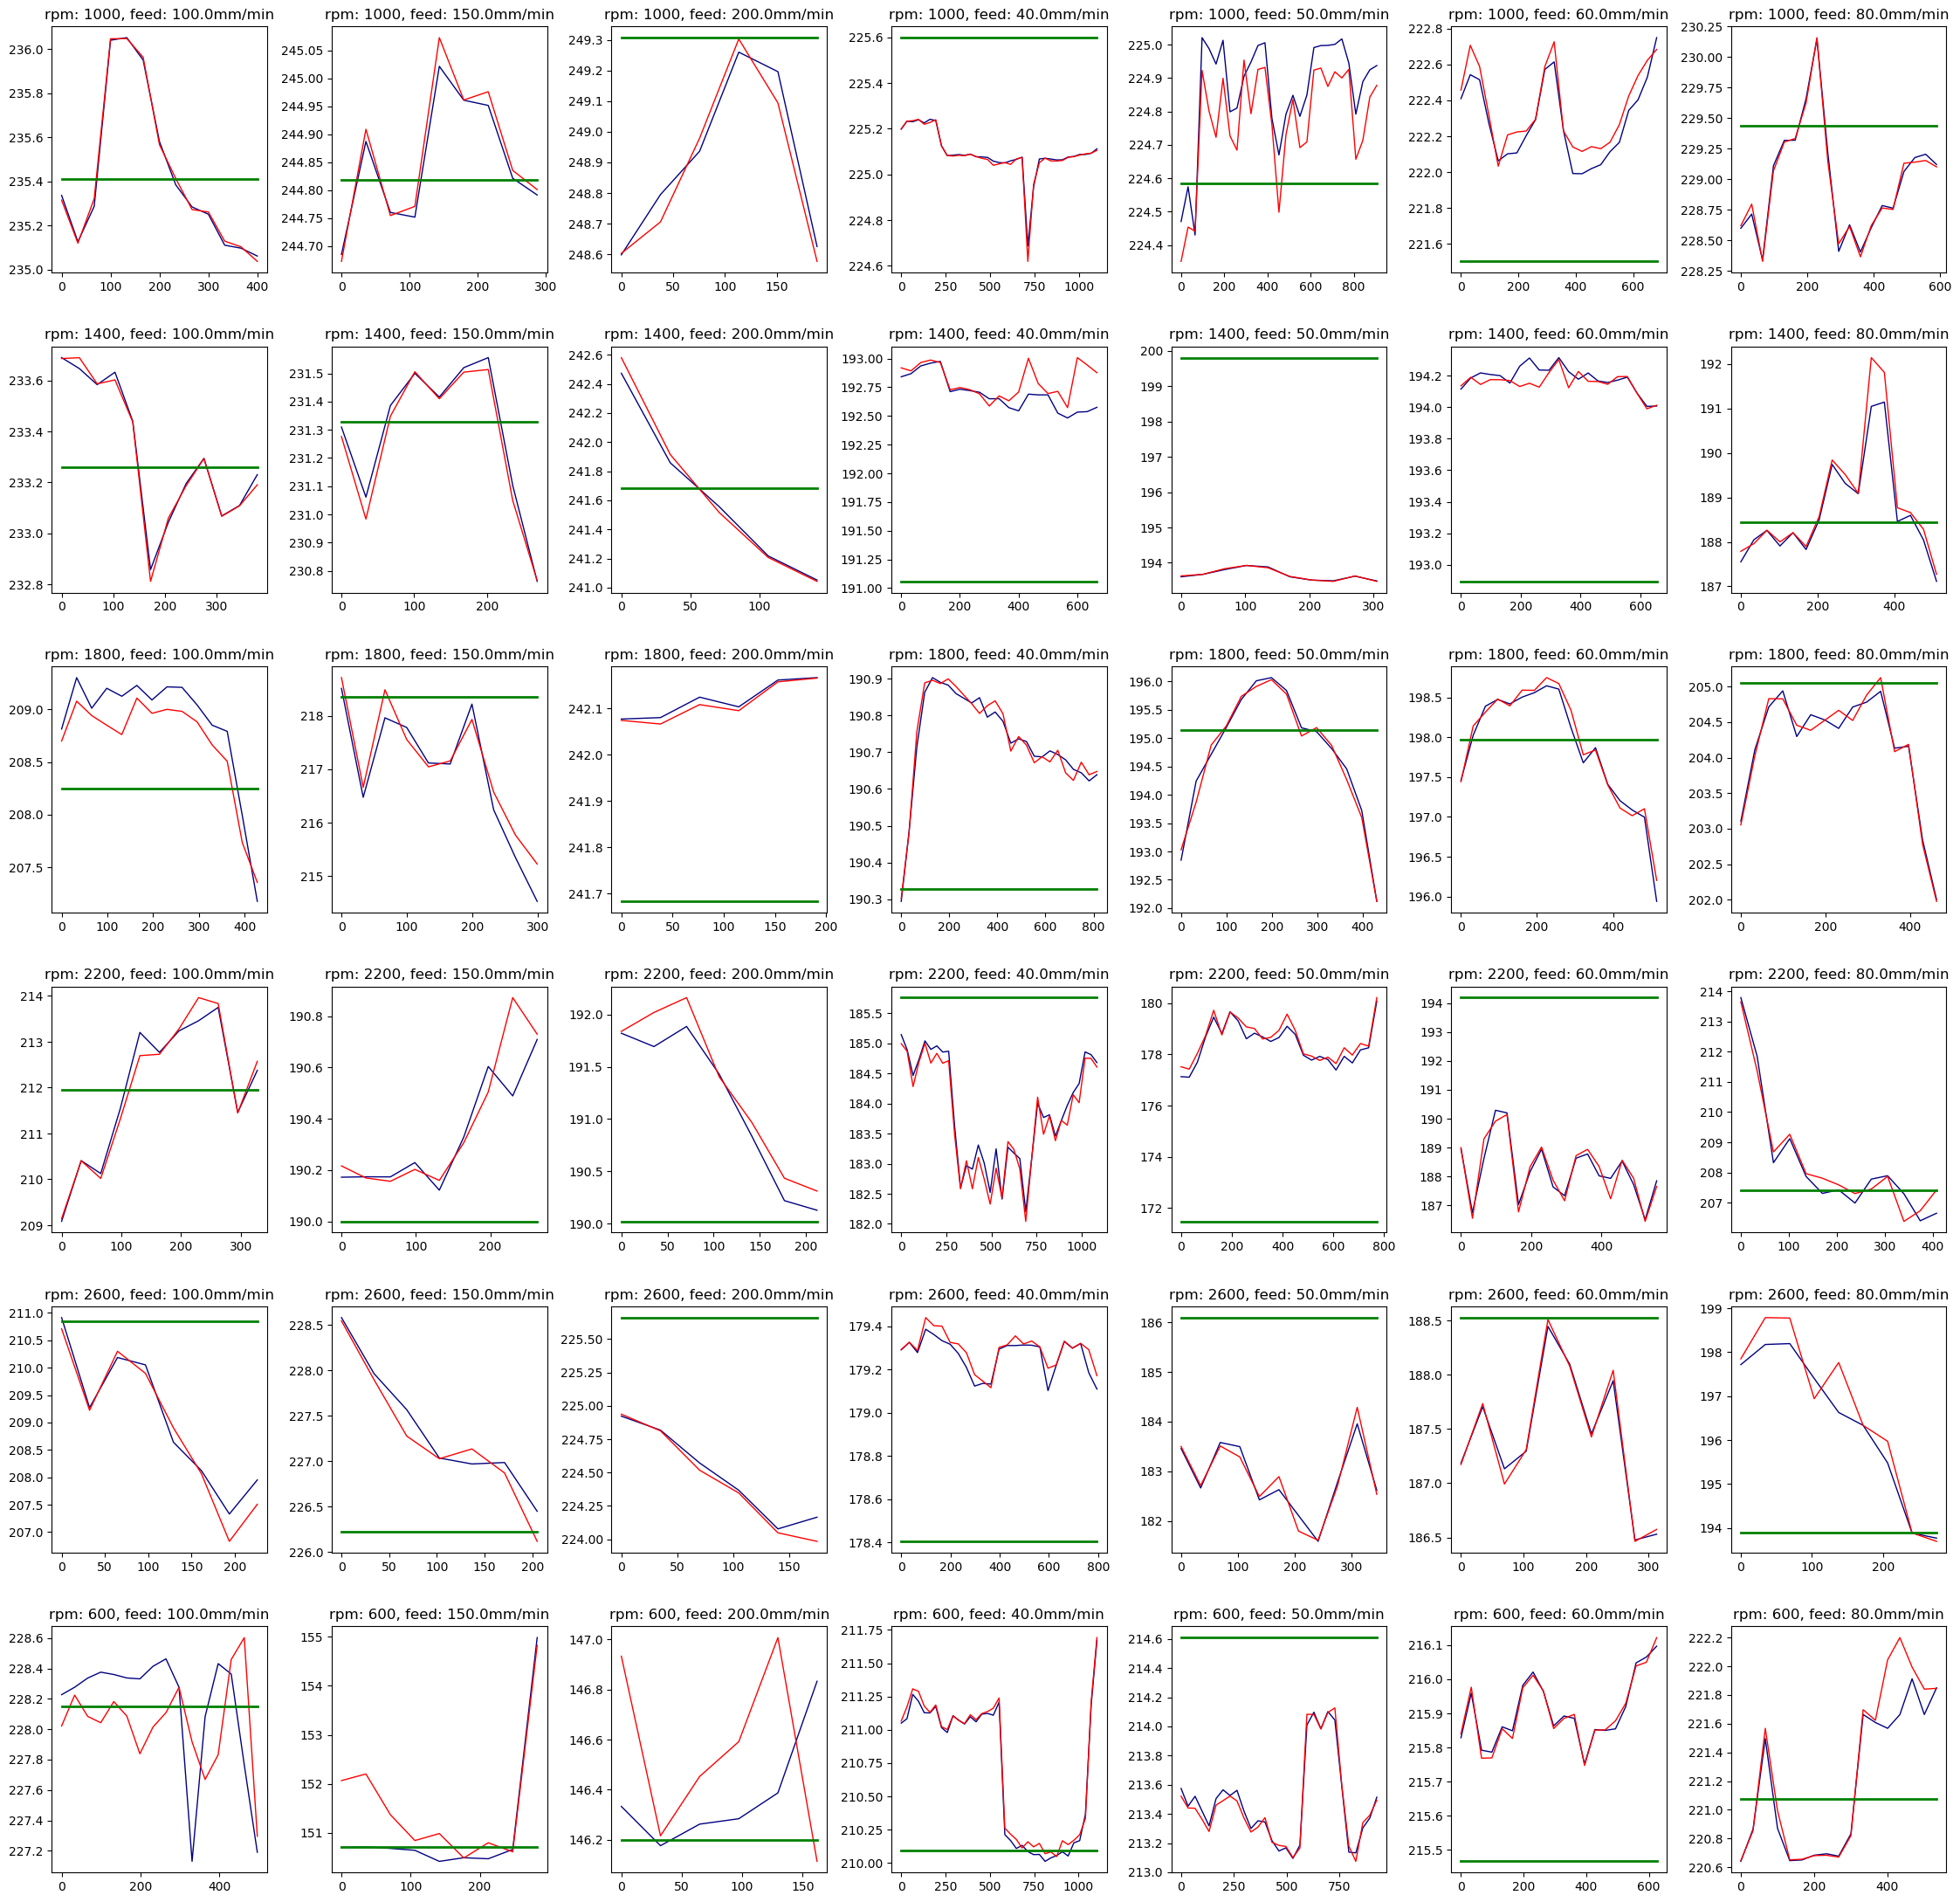

In [159]:
fig = plt.figure(figsize=(28, 28), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
with torch.no_grad():
    ini = 0
    for key in rpm_dict:
        for num, plot_df in enumerate(rpm_dict[key]):
            ax = fig.add_subplot(6,7,ini+num+1)
            line_X = np.linspace(0, plot_df["Z-Load"].shape[0], plot_df["Z-Load"].shape[0]//bs+1)
            features = mms.transform(plot_df[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values)
            
            load_values = features[:, 2]
            sigma = np.std(load_values)
            line_Y_uts = features[:, -1]
            line_Y_uts = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y_uts)))[:, -1]
            line_Y_uts = mean_generator(line_Y_uts, bs)
            
            line_Y = np.squeeze(test_model(torch.from_numpy(features[:, :-1]).float())).numpy()
            line_Y = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y)))[:, -1]
            line_Y = mean_generator(line_Y, bs)
            
            noisy_values = load_values + np.random.normal(0,sigma,plot_df["Z-Load"].shape)
            line_Y_noise = np.squeeze(test_model(torch.from_numpy(np.column_stack((features[:, :-2], noisy_values))).float())).numpy()
#             print(features[:, :-2].shape, noisy_values.shape)
            line_Y_noise = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y_noise)))[:, -1]
            line_Y_noise = mean_generator(line_Y_noise, bs)
    
            vel = round(plot_df['X-Velocity'].iloc[:100].mean(), -1)

            ax.plot(line_X, line_Y, color='navy', linewidth=1, label='Normal')
            ax.plot(line_X, line_Y_noise, color='red', linewidth=1, label='Noisy')
            ax.plot(line_X, line_Y_uts, color='green', linewidth=2, label='UTS')
            ax.set_title("rpm: {}, feed: {}mm/min".format(key, vel))

#             ts, k1, k2, s1, s2 = tstd(line_Y_noise), kurtosis(line_Y), kurtosis(line_Y_noise), skew(line_Y), skew(line_Y_noise)
#             row_list.append([key, round(plot_df.iloc[0:10]['X-Velocity'].mean(), -1), "O: {:0.2f}, N: {:0.2f}".format(sigma, ts), 
#                            "O: {:0.2f}, N: {:0.2f}".format(s1, s2), "O: {:0.2f}, N: {:0.2f}".format(k1, k2)])
#             rpm_review[key].append({'vel': vel, 'std_o': sigma, 'std_n': ts, 'skew_o': s1, 'skew_n': s2, 'kurt_o': k1, 'kurt_n': k2})
        ini += num+1
